# 3 Operational Complexity



In [10]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

file_path = r"/Users/annani/Downloads/champions_group_data.xlsx"

df = pd.read_excel(file_path)

df.columns = df.columns.str.strip()

print("Original shape:", df.shape)

if "Company Status (Active/Inactive)" in df.columns:
    df = df[df["Company Status (Active/Inactive)"] == "Active"].copy()

df["Employees Total"] = pd.to_numeric(df["Employees Total"], errors="coerce")
df = df[~df["Employees Total"].isna()].copy()

print("After filtering:", df.shape)

hardware_cols = [
    "No. of PC",
    "No. of Desktops",
    "No. of Laptops",
    "No. of Routers",
    "No. of Servers",
    "No. of Storage Devices"
]

range_map = {
    "1 to 10": 1,
    "11 to 50": 2,
    "51 to 100": 3,
    "101 to 500": 4,
    "501 to 1000": 5
}

def map_range_to_score(x):
    """Turn '1 to 10' etc into 1–5 score, missing -> 0."""
    if pd.isna(x):
        return 0
    s = str(x).strip()
    if s == "":
        return 0
    return range_map.get(s, 0)

for col in hardware_cols:
    score_col = col + "_score"
    df[score_col] = df[col].apply(map_range_to_score)

score_cols = [c + "_score" for c in hardware_cols]


df["infra_total_score"] = df[score_cols].sum(axis=1)

df["infra_variety"] = (df[score_cols] > 0).sum(axis=1)

df["infra_per_employee"] = df["infra_total_score"] / (df["Employees Total"] + 1)

df["log_employees"] = np.log(df["Employees Total"] + 1)

feature_cols = ["log_employees", "infra_total_score", "infra_variety", "infra_per_employee"]

print(df[feature_cols].describe())

scaler = StandardScaler()
X = scaler.fit_transform(df[feature_cols])

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

print("PCA variance explained:", pca.explained_variance_ratio_.sum())

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

df["complexity_cluster_raw"] = cluster_labels

cluster_summary = df.groupby("complexity_cluster_raw")[feature_cols].mean()
ordered_clusters = cluster_summary["infra_total_score"].sort_values().index.tolist()

cluster_to_tier = {
    ordered_clusters[0]: "Low",
    ordered_clusters[1]: "Medium",
    ordered_clusters[2]: "High"
}

df["Operational Complexity Tier"] = df["complexity_cluster_raw"].map(cluster_to_tier)

print("Cluster sizes:")
print(df["Operational Complexity Tier"].value_counts())

Original shape: (8559, 72)
After filtering: (8559, 72)
       log_employees  infra_total_score  infra_variety  infra_per_employee
count    8559.000000        8559.000000    8559.000000         8559.000000
mean        1.702674           4.960042       4.657787            1.695627
std         1.629887           1.759039       1.533251            1.617186
min         0.000000           0.000000       0.000000            0.000000
25%         0.000000           3.000000       3.000000            0.269231
50%         1.609438           6.000000       5.000000            1.000000
75%         3.091042           6.000000       6.000000            3.000000
max         8.098947          19.000000       6.000000            5.000000
PCA variance explained: 0.9548855763594641
Cluster sizes:
Operational Complexity Tier
High      4212
Low       3237
Medium    1110
Name: count, dtype: int64


## Methodology 

Firm-level operational complexity was analysed using observable infrastructure and size characteristics derived directly from the raw dataset. Hardware quantities (PCs, desktops, laptops, routers, servers, and storage devices), originally reported in ranges, were converted into ordinal scores and aggregated to form an overall infrastructure footprint measure. This was combined with firm size (log-transformed employee count), infrastructure variety, and infrastructure intensity (infrastructure per employee) to characterise operational complexity. All features were standardised prior to analysis. Principal Component Analysis (PCA) was applied to project firms into two dimensions for visualisation, while K-means clustering (K = 3) was used to group firms into Low, Medium, and High operational complexity tiers based on similarities across the full feature set. The resulting clusters were evaluated using a PCA scatter plot to assess separation, a bar chart of average infrastructure footprint to compare structural differences across tiers, and a boxplot of firm size to examine how operational complexity relates to scale.

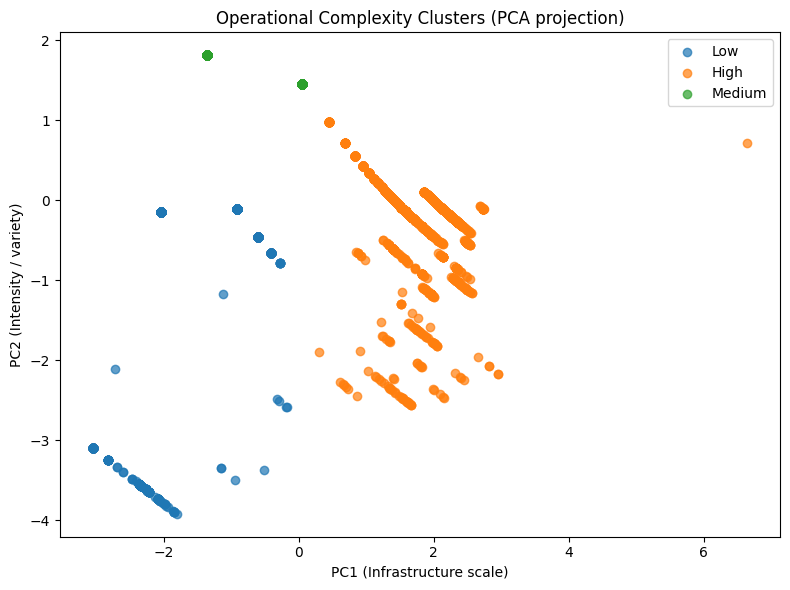

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for tier in df["Operational Complexity Tier"].unique():
    mask = df["Operational Complexity Tier"] == tier
    plt.scatter(
        df.loc[mask, "PC1"],
        df.loc[mask, "PC2"],
        label=tier,
        alpha=0.7
    )

plt.xlabel("PC1 (Infrastructure scale)")
plt.ylabel("PC2 (Intensity / variety)")
plt.title("Operational Complexity Clusters (PCA projection)")
plt.legend()
plt.tight_layout()
plt.show()


The PCA plot shows a clear and intuitive separation between firms with different levels of operational complexity. Firms classified as High complexity cluster mainly on the right side of the chart, indicating larger and heavier IT infrastructure footprints, while Low complexity firms appear on the left, reflecting simpler and lighter setups. Medium complexity firms sit between these two groups, with some natural overlap, suggesting that operational complexity increases gradually rather than in strict categories. The horizontal axis (PC1) is largely driven by overall infrastructure scale, whereas the vertical axis (PC2) captures differences in how intensively or diversely infrastructure is deployed relative to firm size. Overall, the distribution confirms that the clustering meaningfully distinguishes firms based on observable differences in operational and IT complexity, rather than random variation.

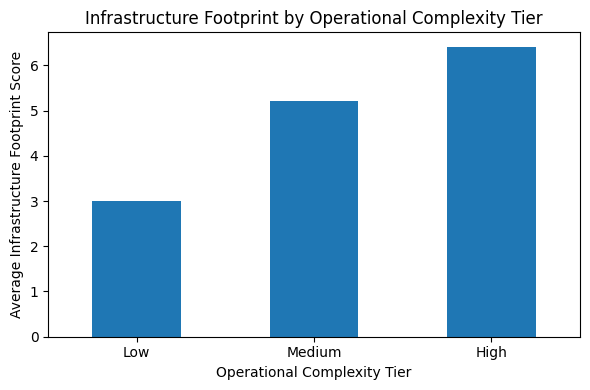

In [12]:
import matplotlib.pyplot as plt

avg_infra = (
    df.groupby("Operational Complexity Tier")["infra_total_score"]
      .mean()
      .sort_values()
)

plt.figure(figsize=(6, 4))
avg_infra.plot(kind="bar")

plt.ylabel("Average Infrastructure Footprint Score")
plt.xlabel("Operational Complexity Tier")
plt.title("Infrastructure Footprint by Operational Complexity Tier")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The bar chart shows a clear and consistent increase in average infrastructure footprint across the three operational complexity tiers. Firms classified as Low complexity have the smallest average footprint, reflecting relatively simple and limited IT setups, while High complexity firms exhibit the largest footprints, indicating substantially heavier and more extensive infrastructure requirements. Medium complexity firms fall between these two groups, reinforcing the idea that operational complexity increases progressively rather than abruptly. Overall, the steady upward pattern confirms that the complexity tiers align closely with underlying differences in infrastructure scale, providing further validation that the classification captures meaningful variations in firms’ operational and IT intensity.

<Figure size 600x400 with 0 Axes>

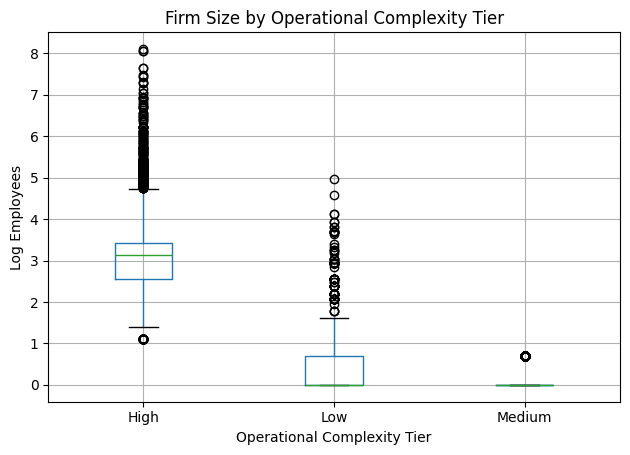

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

df.boxplot(
    column="log_employees",
    by="Operational Complexity Tier"
)

plt.ylabel("Log Employees")
plt.xlabel("Operational Complexity Tier")
plt.title("Firm Size by Operational Complexity Tier")
plt.suptitle("") 
plt.tight_layout()
plt.show()


---

The boxplot shows a clear relationship between firm size and operational complexity. Firms in the High complexity tier tend to be substantially larger, with a higher median and wider spread in log employee counts, indicating both greater scale and greater variation in firm size. In contrast, Low complexity firms are generally smaller, with a lower median and a tighter distribution, reflecting more limited operational scale. Medium complexity firms remain concentrated at the lower end of the size distribution, suggesting that moderate operational complexity in this sample does not necessarily require large firm size. Overall, the distribution indicates that while firm size is strongly associated with higher operational complexity, size alone does not fully determine complexity, reinforcing the role of infrastructure intensity and configuration alongside scale.